# 📊 Model Stability Analysis

This notebook analyzes the stability of our fraud detection model across different time periods and data distributions.

## 📋 Key Components

1. **Data Analysis**
   - Population stability analysis
   - Feature stability analysis
   - Target stability analysis

2. **Model Performance**
   - Performance across time periods
   - Stability metrics calculation
   - Drift detection

3. **Visualization**
   - Stability plots
   - Distribution comparisons
   - Performance trends

## 🛠️ Setup Environment <a name="setup"></a>

In [1]:
%reload_ext autoreload
%autoreload 2

**Introduction**

In the real world of machine learning, particularly in fraud detection, disease diagnosis, or anomaly detection, we often face a common challenge: imbalanced datasets. When one class significantly outnumbers the other, our models can become biased, leading to suboptimal performance where the minority class - often the one we're most interested in - gets overlooked.

## 📚 Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
# import model libraries
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve
import pickle

## 📥 Load Data and Model

In [3]:
print("Loading model and data...")
# Load model
optuna_model = pickle.load(open('../models/optuna_model.pkl', 'rb'))

# Load data
train = pd.read_parquet('../data/train_data.parquet')
train_y = train['is_fraud']
metadata_columns = ['trans_date_trans_time', 'gender', 'street']
train_X = train.drop(columns=['is_fraud'] + metadata_columns)

oot = pd.read_parquet('../data/oot_data.parquet')
oot_y = oot['is_fraud']
oot_X = oot.drop(columns=['is_fraud'] + metadata_columns)
print("Model and data loaded.")

Loading model and data...
Model and data loaded.


## METRICS

## 🔄 Model Drift Analysis
Population Stability Index (PSI) is used to measure score distribution drift over time. 

Interpretation guidelines:
- PSI < 0.1: No significant change, model can continue to be used
- 0.1 ≤ PSI < 0.2: Minor changes detected, consider monitoring closely
- PSI ≥ 0.2: Significant changes detected, model retraining recommended

In [4]:
def calculate_psi(expected, actual, n_bins=10):
    """Calculate the Population Stability Index."""
    # Define bins based on the 'expected' distribution
    breakpoints = np.histogram(expected, n_bins)[1]
    
    # Calculate the percentage of observations in each bin
    expected_percents = np.histogram(expected, breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, breakpoints)[0] / len(actual)
    
    # Replace zeros with a small number to avoid division by zero
    expected_percents = np.clip(expected_percents, 0.0001, None)
    actual_percents = np.clip(actual_percents, 0.0001, None)
    
    # Calculate PSI value
    psi_value = (expected_percents - actual_percents) * np.log(expected_percents / actual_percents)
    return np.sum(psi_value)

print("\nCalculating PSI for model score drift...")
y_pred_train = optuna_model.predict_proba(train_X)[:,1]
y_pred_oot = optuna_model.predict_proba(oot_X)[:,1]
psi = calculate_psi(y_pred_train, y_pred_oot)
print(f'PSI (train vs OOT): {psi:.4f}')
if psi >= 0.2:
    print("Drift detected: PSI is >= 0.2. Model retraining may be needed.")
elif psi >= 0.1:
    print("Some drift detected: PSI is >= 0.1. Monitor closely.")
else:
    print("No significant drift detected: PSI is < 0.1.")


Calculating PSI for model score drift...
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
[LightGBM] [Warning] min_data_in_leaf is set=191, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=191
PSI (train vs OOT): 0.0006
No significant drift detected: PSI is < 0.1.


## 🔍 Data Drift Detection
Monitor changes in feature distributions and importance over time. We'll analyze:
- Feature importance drift using SHAP values
- Distribution drift using statistical tests
- Categorical variable drift using Chi-Square tests

### Feature Importance Drift
Use SHAP values to analyze changes in feature importance between training and obsevation datasets. This helps identify:
- Which features are becoming more/less important over time
- Potential shifts in feature relationships
- Model behavior changes in production
- Stability of feature contributions to predictions

SHAP values provide a unified measure of feature importance that:
- Considers both the magnitude and direction of feature impacts
- Maintains consistency across different model types
- Helps explain individual predictions and global patterns
- Enables comparison of feature importance across different time periods

## Feature Importance Drift with SHAP

In [5]:
import shap


Calculating feature importance drift with SHAP...


/Users/valeria.verzi/IKN/IKN-CAIO/fraud-modeling/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


Top 10 features by importance and their drift:
                        feature  train_importance  oot_importance  \
2                           amt          0.368220        0.365070   
11  transaction_time_of_the_day          0.112684        0.112831   
1                      category          0.077192        0.077228   
9                     age_group          0.003369        0.003411   
6                      city_pop          0.001839        0.001843   
10  transaction_day_of_the_week          0.001186        0.001036   
0                      merchant          0.001140        0.001133   
8                     unix_time          0.001072        0.000953   
4                         state          0.000584        0.000659   
3                          city          0.000234        0.000234   

           drift  
2  -3.149808e-03  
11  1.465609e-04  
1   3.542598e-05  
9   4.186907e-05  
6   4.336348e-06  
10 -1.501897e-04  
0  -6.934229e-06  
8  -1.191234e-04  
4   7.483839e-05  
3  

/Users/valeria.verzi/IKN/IKN-CAIO/fraud-modeling/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


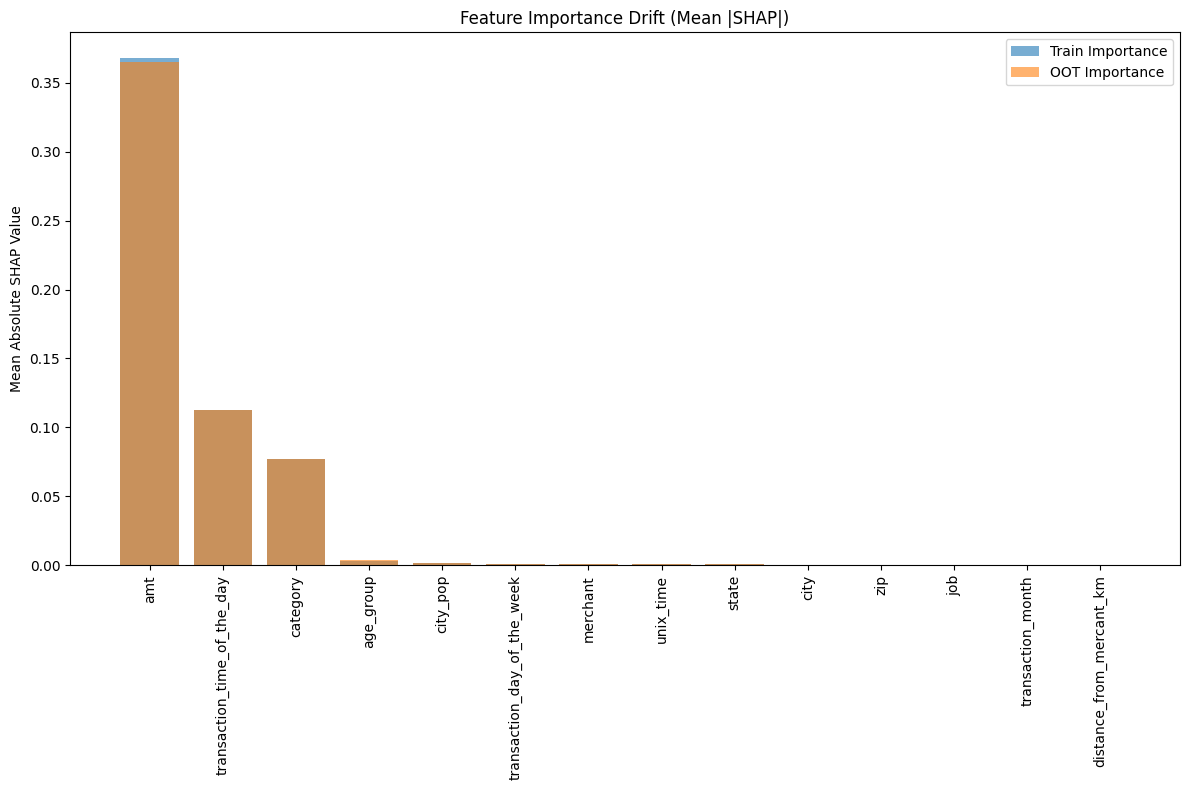

Feature importance drift plot generated.


In [6]:
print("\nCalculating feature importance drift with SHAP...")
explainer = shap.TreeExplainer(optuna_model)
shap_values_train = explainer.shap_values(train_X)
shap_values_oot = explainer.shap_values(oot_X)

# Compare mean absolute SHAP values
train_importance = np.abs(shap_values_train).mean(axis=0)
oot_importance = np.abs(shap_values_oot).mean(axis=0)
features = train_X.columns

# Create a DataFrame for easier plotting
importance_df = pd.DataFrame({
    'feature': features,
    'train_importance': train_importance,
    'oot_importance': oot_importance
})
importance_df['drift'] = importance_df['oot_importance'] - importance_df['train_importance']
importance_df = importance_df.sort_values(by='train_importance', ascending=False)

print("Top 10 features by importance and their drift:")
print(importance_df.head(10))

# Plotting the drift
plt.figure(figsize=(12, 8))
plt.bar(importance_df['feature'], importance_df['train_importance'], alpha=0.6, label='Train Importance')
plt.bar(importance_df['feature'], importance_df['oot_importance'], alpha=0.6, label='OOT Importance')
plt.xticks(rotation=90)
plt.title('Feature Importance Drift (Mean |SHAP|)')
plt.ylabel('Mean Absolute SHAP Value')
plt.legend()
plt.tight_layout()
plt.show()
print("Feature importance drift plot generated.")

## Distribution Drift Example for a single feature


Plotting distribution drift for the most important feature: 'amt'


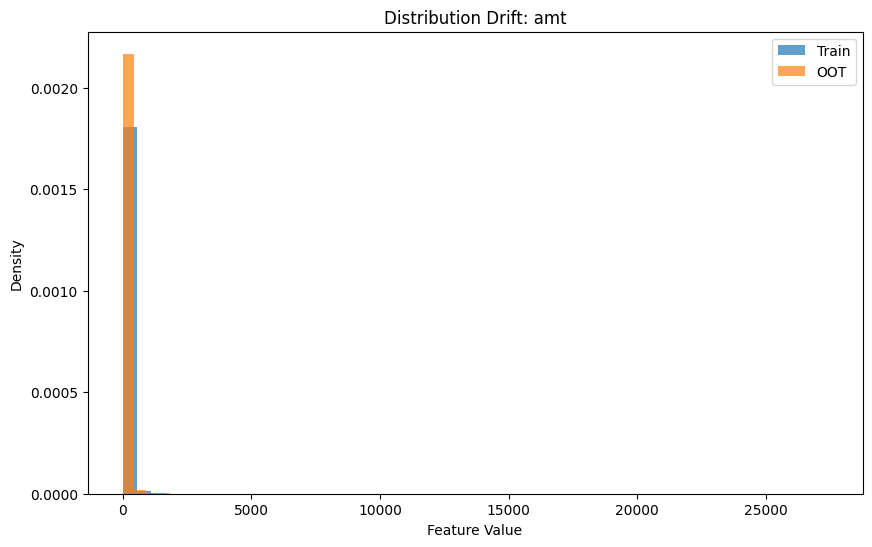

Distribution drift plot generated.


In [7]:
feature_to_check = importance_df.iloc[0]['feature'] # Check the most important feature
print(f"\nPlotting distribution drift for the most important feature: '{feature_to_check}'")

plt.figure(figsize=(10, 6))
plt.hist(train_X[feature_to_check], bins=50, alpha=0.7, label='Train', density=True)
plt.hist(oot_X[feature_to_check], bins=50, alpha=0.7, label='OOT', density=True)
plt.title(f'Distribution Drift: {feature_to_check}')
plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.legend()
plt.show()
print("Distribution drift plot generated.") 